In [46]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from IPython.display import display as display_fn
from IPython.display import Image,clear_output

Preprocessing Image

In [47]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape>3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)
def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

Load image

In [48]:
content_path = './drive/MyDrive/image/baby.jpg'
style_path = './drive/MyDrive/image/The-Starry-Night.jpg'

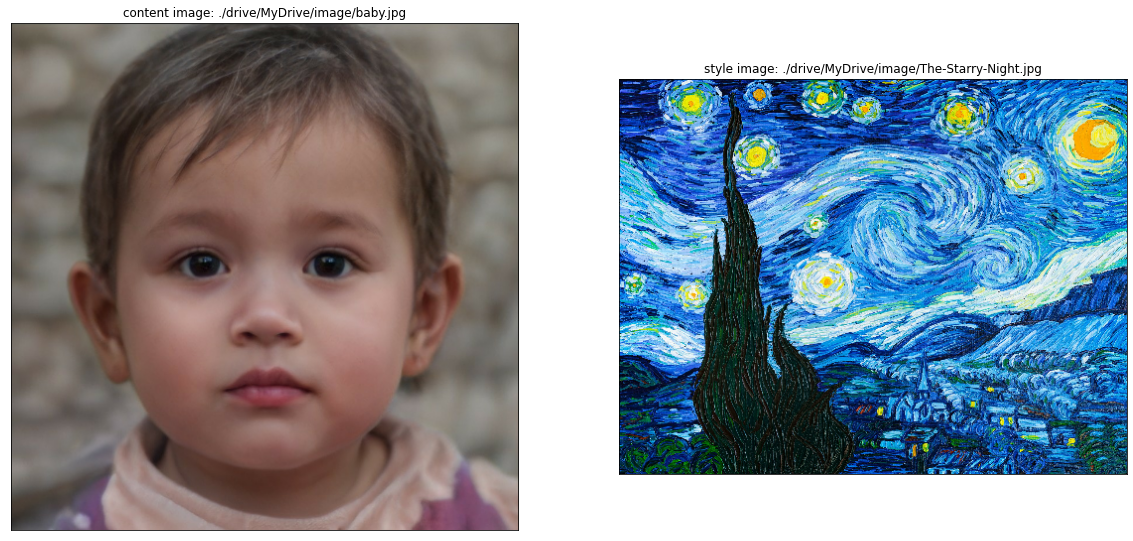

In [49]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

In [ ]:
K.clear_session()

#download Inception model
inception_model = tf.keras.applications.InceptionV3()
inception_model.summary()

#delete temporal model
del inception_model

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

có tổng cộng 94 layers conv2D, được đánh số từ 'conv2d đến conv2d_93

In [50]:
#chọn layer cho content và style
content_layers = ['conv2d_88']
#chọn ngẫu nhiên 1 số layer tùy ý cho style
style_layers = ['conv2d_4','conv2d_13','conv2d_18','conv2d_23','conv2d_33']

content_and_style_layers = style_layers + content_layers

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)
content_and_style_layers

['conv2d_4', 'conv2d_13', 'conv2d_18', 'conv2d_23', 'conv2d_33', 'conv2d_88']

Thiết lập đầu ra với Inception model và sử dụng weight  của 'imagenet'

In [51]:
def InceptionV3_model(layer_names):
  inception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
  inception.trainable = False
  outputs = [inception.get_layer(layer_name).output for layer_name in layer_names]
  model = tf.keras.models.Model(inputs =inception.input,outputs=outputs)
  return model

In [52]:
#clear session để đảm bảo sự nhất quán khi chạy lại cell
K.clear_session()

inception = InceptionV3_model(content_and_style_layers)
inception.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

###Tính Style Loss

In [53]:
def get_style_loss(features,targets):
  return tf.reduce_mean(tf.square(features-targets))

### Tính Content Loss

In [54]:
def get_content_loss(features,targets):
  return 0.5*tf.reduce_sum(tf.square(features-targets))

### Tính Gram Matrix
sử dụng tf.linalg.einsum

In [55]:
def gram_matrix(input_tensor):
  gram = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]

  #lấy số vị trí để scale(=height*width)
  num_locations = tf.cast(height*width,dtype = tf.float32)
  scaled_gram = gram/num_locations
  return scaled_gram

###Get style image features

In [56]:
def get_style_image_features(image):
  preprocessed_style_image = preprocess_image(image)
  outputs = inception(preprocessed_style_image)
  style_outputs = outputs[:NUM_STYLE_LAYERS]
  gram_style_features = [gram_matrix(input_tensor) for input_tensor in style_outputs]
  return gram_style_features

### Get content image features

In [57]:
def get_content_image_features(image):
  preprocessed_content_image = preprocess_image(image)
  outputs = inception(preprocessed_content_image)
  content_outputs = outputs[-NUM_CONTENT_LAYERS:]
  return content_outputs


###Calculate total loss


```
total_loss = beta*style_loss + alpha*content_loss
```



In [58]:
def style_content_loss(style_targets,style_outputs,content_targets,content_outputs,style_weight,content_weight):
  #sum of style loss
  style_loss = tf.add_n([get_style_loss(style_output,style_target) for style_output,style_target in zip(style_targets,style_outputs)])
  content_loss = tf.add_n([get_content_loss(feature,target) for feature,target in zip(content_outputs,content_targets)])
  total_loss = style_weight*style_loss/NUM_STYLE_LAYERS+content_weight*content_loss/NUM_CONTENT_LAYERS
  return total_loss

Calculate Gradients

In [59]:
def calculate_gradient(image,style_targets,content_targets,style_weight,content_weight):
  with tf.GradientTape() as tape:
    style_features = get_style_image_features(image)
    content_features = get_content_image_features(image)
    loss = style_content_loss(style_targets,style_features,content_targets,content_features,style_weight,content_weight)
  gradients = tape.gradient(loss,image)
  return gradients

Update image with the style

In [60]:
def update_image_with_style(image,style_targets,content_targets,style_weight,content_weight,optimizer):
  gradients = calculate_gradient(image,style_targets,content_targets,style_weight,content_weight)
  optimizer.apply_gradients([(gradients,image)])
  image.assign(clip_image_values(image,min_value=0.0,max_value=255.0))


### GENERATE IMAGE

In [61]:
def fit_style_transfer(style_image,content_image,style_weight=1e-2,content_weight=1e-4,
                       optimizer='adam',epochs=1,step_per_epoch=1):
  images=[]
  step = 0
  style_target = get_style_image_features(style_image)
  content_target = get_content_image_features(content_image)
  
  # Khoi tao anh
  generated_image = tf.cast(content_image,dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  #collect the image updates starting from the content image
  images.append(content_image)

  for n in range(epochs):
    for m in range(step_per_epoch):
      step += 1
      update_image_with_style(generated_image,style_target,content_target,style_weight,content_weight,optimizer)
      print('.',end='')
      if (m+1) %10 ==0:
        images.append(generated_image)
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)
    images.append(generated_image)
    print(f'Train step: {step}')
  generated_image = tf.cast(generated_image,dtype=tf.uint8)
  return generated_image, images

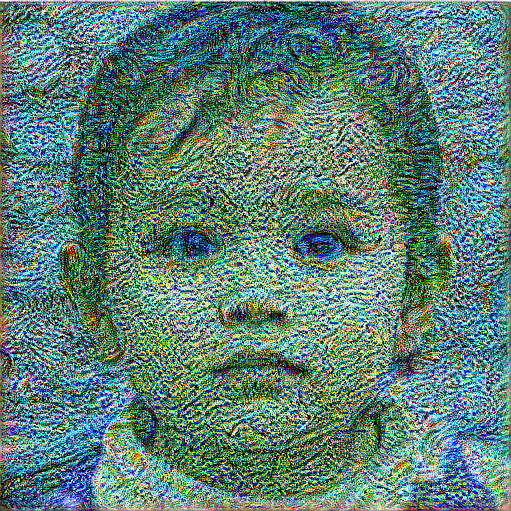

Train step: 1000


In [62]:
style_weight = 1
content_weight = 1e-30 #content_weight nen gan hoac bang 0

#xac dinh ham toi uu,learing rate giam tren epoch
adam = tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0,decay_steps=100,decay_rate=0.80))

#train
stylized_image, display_images = fit_style_transfer(style_image = style_image,content_image=content_image,style_weight=style_weight,
                                                    content_weight =content_weight,optimizer=adam,epochs=10,step_per_epoch=100)